# **Import the Libraries**

In [34]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
#Import the Libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Install umap
!pip install umap-learn
import umap

# **Load data**

In [36]:
# Read data from CSV file
data = pd.read_csv("/content/drive/MyDrive/Data Science/Fifa_world_cup_matches.csv")
data.head()

,team1,team2,possession team1,possession team2,possession in contest,number of goals team1,number of goals team2,date,hour,category,total attempts team1,total attempts team2,conceded team1,conceded team2,goal inside the penalty area team1,goal inside the penalty area team2,goal outside the penalty area team1,goal outside the penalty area team2,assists team1,assists team2,on target attempts team1,on target attempts team2,off target attempts team1,off target attempts team2,attempts inside the penalty area team1,attempts inside the penalty area team2,attempts outside the penalty area team1,attempts outside the penalty area team2,left channel team1,left channel team2,left inside channel team1,left inside channel team2,central channel team1,central channel team2,right inside channel team1,right inside channel team2,right channel team1,right channel team2,total offers to receive team1,total offers to receive team2,inbehind offers to receive team1,inbehind offers to receive team2,inbetween offers to receive team1,inbetween offers to receive team2,infront offers to receive team1,infront offers to receive team2,receptions between midfield and defensive lines team1,receptions between midfield and defensive lines team2,attempted line breaks team1,attempted line breaks team2,completed line breaksteam1,completed line breaks team2,attempted defensive line breaks team1,attempted defensive line breaks team2,completed defensive line breaksteam1,completed defensive line breaks team2,yellow cards team1,yellow cards team2,red cards team1,red cards team2,fouls against team1,fouls against team2,offsides team1,offsides team2,passes team1,passes team2,passes completed team1,passes completed team2,crosses team1,crosses team2,crosses completed team1,crosses completed team2,switches of play completed team1,switches of play completed team2,corners team1,corners team2,free kicks team1,free kicks team2,penalties scored team1,penalties scored team2,goal preventions team1,goal preventions team2,own goals team1,own goals team2,forced turnovers team1,forced turnovers team2,defensive pressures applied team1,defensive pressures applied team2
0,QATAR,ECUADOR,42%,50%,8%,0,2,20 NOV 2022,17 : 00,Group A,5,6,2,0,0,2,0,0,0,1,0,3,5,3,2,4,3,2,15,8,0,7,3,6,1,4,9,6,520,532,116,127,235,187,169,218,5,8,136,155,86,99,9,13,4,7,4,2,0,0,15,15,3,4,450,480,381,409,9,14,4,4,9,9,1,3,19,17,0,1,6,5,0,0,52,72,256,279
1,ENGLAND,IRAN,72%,19%,9%,6,2,21 NOV 2022,14 : 00,Group B,13,8,2,6,6,2,0,0,6,1,7,3,3,4,10,6,3,2,11,3,5,0,2,3,3,1,11,0,1061,212,207,53,386,86,468,73,16,4,238,101,178,45,25,7,16,4,0,2,0,0,9,14,2,2,809,224,730,154,23,8,7,1,12,3,8,0,16,10,0,1,8,13,0,0,63,72,139,416
2,SENEGAL,NETHERLANDS,44%,45%,11%,0,2,21 NOV 2022,17 : 00,Group A,14,9,2,0,0,2,0,0,0,1,3,3,8,5,7,5,7,4,12,11,4,2,2,2,4,7,13,20,502,506,123,117,230,191,149,198,15,14,151,162,89,96,22,22,15,10,2,1,0,0,13,13,2,1,383,438,313,374,19,25,7,8,9,6,6,7,14,14,0,0,9,15,0,0,63,73,263,251
3,UNITED STATES,WALES,51%,39%,10%,1,1,21 NOV 2022,20 : 00,Group B,6,7,1,1,1,1,0,0,1,0,1,3,4,3,4,5,2,2,14,7,5,2,4,5,4,2,11,7,725,436,149,100,336,172,240,164,12,9,199,174,146,103,23,17,15,8,4,2,0,0,15,10,1,1,569,409,509,321,31,15,4,6,5,8,5,3,11,15,0,1,7,7,0,0,81,72,242,292
4,ARGENTINA,SAUDI ARABIA,64%,24%,12%,1,2,22 NOV 2022,11 : 00,Group C,14,3,2,1,1,2,0,0,0,1,6,2,5,0,10,3,4,0,12,3,4,2,5,3,8,3,18,8,650,268,157,69,177,131,316,68,26,9,191,137,127,68,39,15,25,7,0,6,0,0,7,21,10,1,610,267,529,190,29,9,12,2,5,7,9,2,22,16,1,0,4,14,0,0,65,80,163,361


# **Data Cleaning**

In [37]:
# Print data informations
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 88 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   team1                                                  64 non-null     object
 1   team2                                                  64 non-null     object
 2   possession team1                                       64 non-null     object
 3   possession team2                                       64 non-null     object
 4   possession in contest                                  64 non-null     object
 5   number of goals team1                                  64 non-null     int64 
 6   number of goals team2                                  64 non-null     int64 
 7   date                                                   64 non-null     object
 8   hour                                                   64 non-



*   Columns to Drop: [date, hour, category]
*   Column to Convert: [possession team]
*   Correcting Whitespace Issues in Column Names



In [38]:
# Drop unnecessary columns
data = data.drop(labels=['date', 'hour', 'category'], axis=1)
data.head()

# Convert 'possession' columns from object type to integer type
def deletePercent(x):
    return int(x.replace('%', ''))

data['possession team1'] = data['possession team1'].apply(deletePercent)
data['possession team2'] = data['possession team2'].apply(deletePercent)
data['possession in contest'] = data['possession in contest'].apply(deletePercent)

# Rename columns for better readability
# team1_data.columns = team1_data.columns.map(lambda x: x.replace('team1', 'team'))
data = data.rename(columns={'completed line breaksteam1': 'completed line breaks team1',
                            'completed defensive line breaksteam1': 'completed defensive line breaks team1',
                            'attempts inside the penalty area  team2' : 'attempts inside the penalty area team2'})

*   Restructure the data to the desired format.

In [39]:
def getTeamInformation(data, team_name):

    # Filter data for matches involving the team
    team1_data = data[data['team1'] == team_name]
    team2_data = data[data['team2'] == team_name]

    # Select relevant columns for each team data
    team1_related_cols = [col for col in team1_data.columns if 'team1' in col]
    team2_related_cols = [col for col in team2_data.columns if 'team2' in col]
    team1_data = team1_data[team1_related_cols]
    team2_data = team2_data[team2_related_cols]

    # Combine team data with appropriate column renaming
    team1_data.columns = team1_data.columns.str.replace('team1', 'Average')
    team2_data.columns = team2_data.columns.str.replace('team2', 'Average')
    team_data = pd.concat([team1_data, team2_data])

    # Reset index and remove unnecessary column
    team_data = team_data.reset_index()
    team_data = team_data.drop(labels='index', axis=1)

    # Rename 'Average ' prefix to 'name' and calculate average statistics
    team_data = team_data.rename(columns={'Average': 'name'})
    team_data = team_data.drop(labels='name', axis=1)
    team_data = team_data.mean()
    team_data = pd.DataFrame(team_data).transpose()     # Reshape to DataFrame

    # Rename index to the team name
    team_data = team_data.rename(index={0: team_name})

    return team_data

# Initialize empty DataFrame to store results
data_preproccessed = pd.DataFrame()

# Get list of team names
team_list = list(set(data['team1'].values))

# Get information for each team and concatenate DataFrames
for name in team_list:
    team_df = getTeamInformation(data, name)
    data_preproccessed = pd.concat([data_preproccessed, team_df])

# Sort result by team name
data_preproccessed = data_preproccessed.sort_index()

# Drop unnecessary columns
data_preproccessed = data_preproccessed.drop(labels=['red cards Average', 'yellow cards Average', 'own goals Average'], axis=1)

data_preproccessed

,possession Average,number of goals Average,total attempts Average,conceded Average,goal inside the penalty area Average,goal outside the penalty area Average,assists Average,on target attempts Average,off target attempts Average,attempts inside the penalty area Average,attempts outside the penalty area Average,left channel Average,left inside channel Average,central channel Average,right inside channel Average,right channel Average,total offers to receive Average,inbehind offers to receive Average,inbetween offers to receive Average,infront offers to receive Average,receptions between midfield and defensive lines Average,attempted line breaks Average,completed line breaks Average,attempted defensive line breaks Average,completed defensive line breaks Average,fouls against Average,offsides Average,passes Average,passes completed Average,crosses Average,crosses completed Average,switches of play completed Average,corners Average,free kicks Average,penalties scored Average,goal preventions Average,forced turnovers Average,defensive pressures applied Average
ARGENTINA,51.142857,2.142857,14.857143,1.142857,2.000000,0.142857,1.142857,6.857143,6.000000,9.428571,5.428571,12.857143,6.571429,7.571429,6.000000,14.428571,656.428571,128.285714,242.428571,285.714286,16.285714,187.000000,130.571429,24.142857,13.571429,14.285714,3.285714,625.000000,548.714286,16.428571,4.285714,5.428571,5.571429,17.571429,0.571429,6.428571,70.571429,241.142857
AUSTRALIA,31.250000,1.000000,6.250000,1.500000,0.750000,0.000000,0.750000,2.250000,2.500000,3.250000,3.000000,9.750000,2.000000,3.250000,3.750000,12.000000,425.750000,99.000000,156.500000,170.250000,7.750000,154.000000,87.000000,15.750000,7.750000,13.000000,0.250000,384.000000,301.500000,14.500000,2.500000,4.000000,2.000000,12.000000,0.000000,15.750000,76.750000,345.750000
BELGIUM,49.666667,0.333333,11.333333,0.666667,0.333333,0.000000,0.333333,3.666667,6.333333,7.666667,3.666667,12.000000,5.333333,5.000000,3.333333,8.000000,643.666667,127.333333,220.000000,296.333333,8.000000,167.000000,112.333333,17.333333,7.666667,10.000000,1.000000,593.000000,522.666667,17.000000,5.333333,4.666667,5.666667,14.333333,0.000000,14.333333,60.000000,274.666667
BRAZIL,50.400000,1.600000,18.000000,0.600000,1.600000,0.000000,1.200000,8.200000,6.800000,11.400000,6.600000,19.600000,8.200000,8.200000,6.800000,15.800000,686.400000,149.000000,263.400000,274.000000,12.800000,181.400000,131.800000,18.200000,11.400000,12.600000,1.600000,601.800000,539.200000,23.200000,4.800000,5.600000,7.400000,17.000000,0.200000,6.800000,72.200000,295.400000
CAMEROON,38.333333,1.333333,9.000000,1.333333,1.333333,0.000000,1.333333,4.666667,2.666667,6.666667,2.333333,7.333333,7.666667,4.000000,4.333333,14.000000,459.000000,100.000000,180.333333,178.666667,9.666667,166.333333,91.000000,18.000000,7.666667,10.666667,0.666667,386.333333,311.333333,17.333333,2.666667,5.666667,4.000000,15.333333,0.000000,14.666667,80.000000,307.333333
CANADA,47.000000,0.666667,11.666667,2.333333,0.333333,0.000000,0.333333,2.000000,6.333333,7.333333,4.333333,15.666667,4.666667,4.333333,5.000000,14.666667,625.666667,150.000000,245.666667,230.000000,9.666667,176.666667,116.000000,19.666667,9.000000,11.000000,2.666667,499.333333,429.333333,18.000000,5.000000,5.333333,4.000000,14.000000,0.000000,9.666667,61.666667,286.666667
COSTA RICA,27.666667,1.000000,4.000000,3.666667,1.000000,0.000000,0.333333,2.333333,0.666667,2.333333,1.666667,6.666667,1.666667,2.333333,0.666667,2.000000,341.000000,76.333333,145.666667,119.000000,4.000000,142.333333,82.000000,9.333333,2.666667,8.000000,4.333333,340.666667,270.000000,7.333333,1.000000,4.000000,0.333333,15.000000,0.000000,21.000000,73.666667,419.000000
CROATIA,48.000000,1.142857,11.571429,1.000000,1.000000,0.142857,1.142857,4.000000,5.142857,6.714286,4.857143,16.714286,5.428571,4.714286,3.857143,13.142857,628.857143,131.428571,253.857143,243.571429,11.857143,197.714286,136.285714,19.000000,10.000000,12.857143,1.571429,610.285714,532.0000

In [40]:
data_preproccessed.describe()

,possession Average,number of goals Average,total attempts Average,conceded Average,goal inside the penalty area Average,goal outside the penalty area Average,assists Average,on target attempts Average,off target attempts Average,attempts inside the penalty area Average,attempts outside the penalty area Average,left channel Average,left inside channel Average,central channel Average,right inside channel Average,right channel Average,total offers to receive Average,inbehind offers to receive Average,inbetween offers to receive Average,infront offers to receive Average,receptions between midfield and defensive lines Average,attempted line breaks Average,completed line breaks Average,attempted defensive line breaks Average,completed defensive line breaks Average,fouls against Average,offsides Average,passes Average,passes completed Average,crosses Average,crosses completed Average,switches of play completed Average,corners Average,free kicks Average,penalties scored Average,goal preventions Average,forced turnovers Average,defensive pressures applied Average
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,43.515848,1.243080,10.970461,1.434375,1.130952,0.093899,0.875149,3.817783,4.838839,6.761830,4.208631,13.256920,4.577976,4.865848,4.556250,11.882738,558.811161,122.073214,218.583482,218.154464,10.635714,169.312574,108.576042,18.247842,9.704018,12.455432,1.951786,488.239807,415.390551,18.249182,4.262798,6.173214,4.413021,14.094866,0.116890,11.798586,70.746205,291.412277
std,8.985081,0.664890,3.457294,0.752015,0.664043,0.125587,0.549268,1.595922,1.774242,2.535967,1.335895,4.454836,1.856362,1.858321,1.578417,4.186128,130.546880,24.136592,46.888312,70.507546,3.749796,17.928381,22.317575,4.068710,3.545601,2.577321,1.048523,127.293254,128.757562,4.511473,1.491754,2.472171,1.823134,2.550192,0.164893,3.674944,7.625520,53.070814
min,27.666667,0.333333,4.000000,0.333333,0.000000,0.000000,0.000000,1.750000,0.666667,2.333333,1.500000,6.666667,1.571429,1.666667,0.666667,2.000000,341.000000,76.333333,145.666667,111.000000,4.000000,142.333333,79.666667,9.333333,2.666667,8.000000,0.250000,327.333333,245.000000,7.333333,1.000000,2.666667,0.333333,9.333333,0.000000,5.750000,56.000000,199.000000
25%,37.666667,0.729167,8.928571,0.950000,0.702381,0.000000,0.333333,2.729167,3.937500,5.666667,3.533333,10.187500,3.625000,3.857143,3.687500,9.500000,469.916667,103.392857,181.821429,179.916667,7.937500,156.250000,90.333333,15.550000,7.383333,10.650000,1.312500,390.500000,320.500000,15.600000,2.928571,4.300000,2.937500,12.250000,0.000000,9.000000,65.291667,260.333333
50%,42.833333,1.250000,11.000000,1.171429,1.000000,0.000000,0.750000,3.416667,4.750000,6.666667,4.000000,12.375000,4.633333,4.583333,4.333333,12.100000,529.833333,122.300000,220.000000,208.291667,9.666667,166.666667,102.833333,18.100000,8.750000,12.000000,1.708333,459.333333,382.000000,17.666667,4.333333,5.514286,4.541667,14.291667,0.000000,11.214286,72.100000,287.083333
75%,48.666667,1.666667,12.287500,2.000000,1.616667,0.200000,1.333333,4.541667,5.666667,7.666667,4.892857,15.785714,5.616667,6.000000,5.083333,14.666667,644.083333,136.500000,252.164286,244.866071,12.575000,178.312500,120.962500,19.666667,11.723214,13.964286,2.616667,593.166667,521.416667,20.892857,5.270833,7.883929,5.517857,15.416667,0.250000,14.666667,76.687500,303.226190
max,69.000000,2.600000,22.333333,3.666667,2.400000,0.333333,2.200000,8.200000,11.000000,15.333333,7.000000,27.000000,8.333333,10.333333,9.250000,20.666667,938.000000,174.666667,314.800000,468.250000,20.750000,217.750000,169.250000,27.750000,18.750000,18.666667,4.333333,954.750000,881.750000,28.000000,7.333333,11.750000,8.3

In [41]:
# Separating Attack and Defense Metrics

# Attack-related metrics
attack = [
    'possession Average', 'number of goals Average', 'total attempts Average', 'goal inside the penalty area Average',
    'goal outside the penalty area Average', 'assists Average', 'on target attempts Average', 'off target attempts Average',
    'attempts inside the penalty area Average', 'attempts outside the penalty area  Average', 'left channel Average',
    'left inside channel Average', 'central channel Average', 'right inside channel Average', 'right channel Average',
    'total offers to receive Average', 'inbehind offers to receive Average', 'receptions between midfield and defensive lines Average',
    'attempted line breaks Average', 'completed line breaks Average', 'attempted defensive line breaks Average', 'completed defensive line breaks Average',
    'offsides Average', 'passes Average', 'passes completed Average', 'crosses Average', 'crosses completed Average', 'switches of play completed Average',
    'corners Average', 'free kicks Average'
]

# Defense-related metrics
defense = [
    'conceded Average', 'fouls against Average',
    'goal preventions Average', 'own goals Average','forced turnovers Average', 'defensive pressures applied Average'
]

# attack_data = result_data[attack]
# defense_data = result_data[defense]

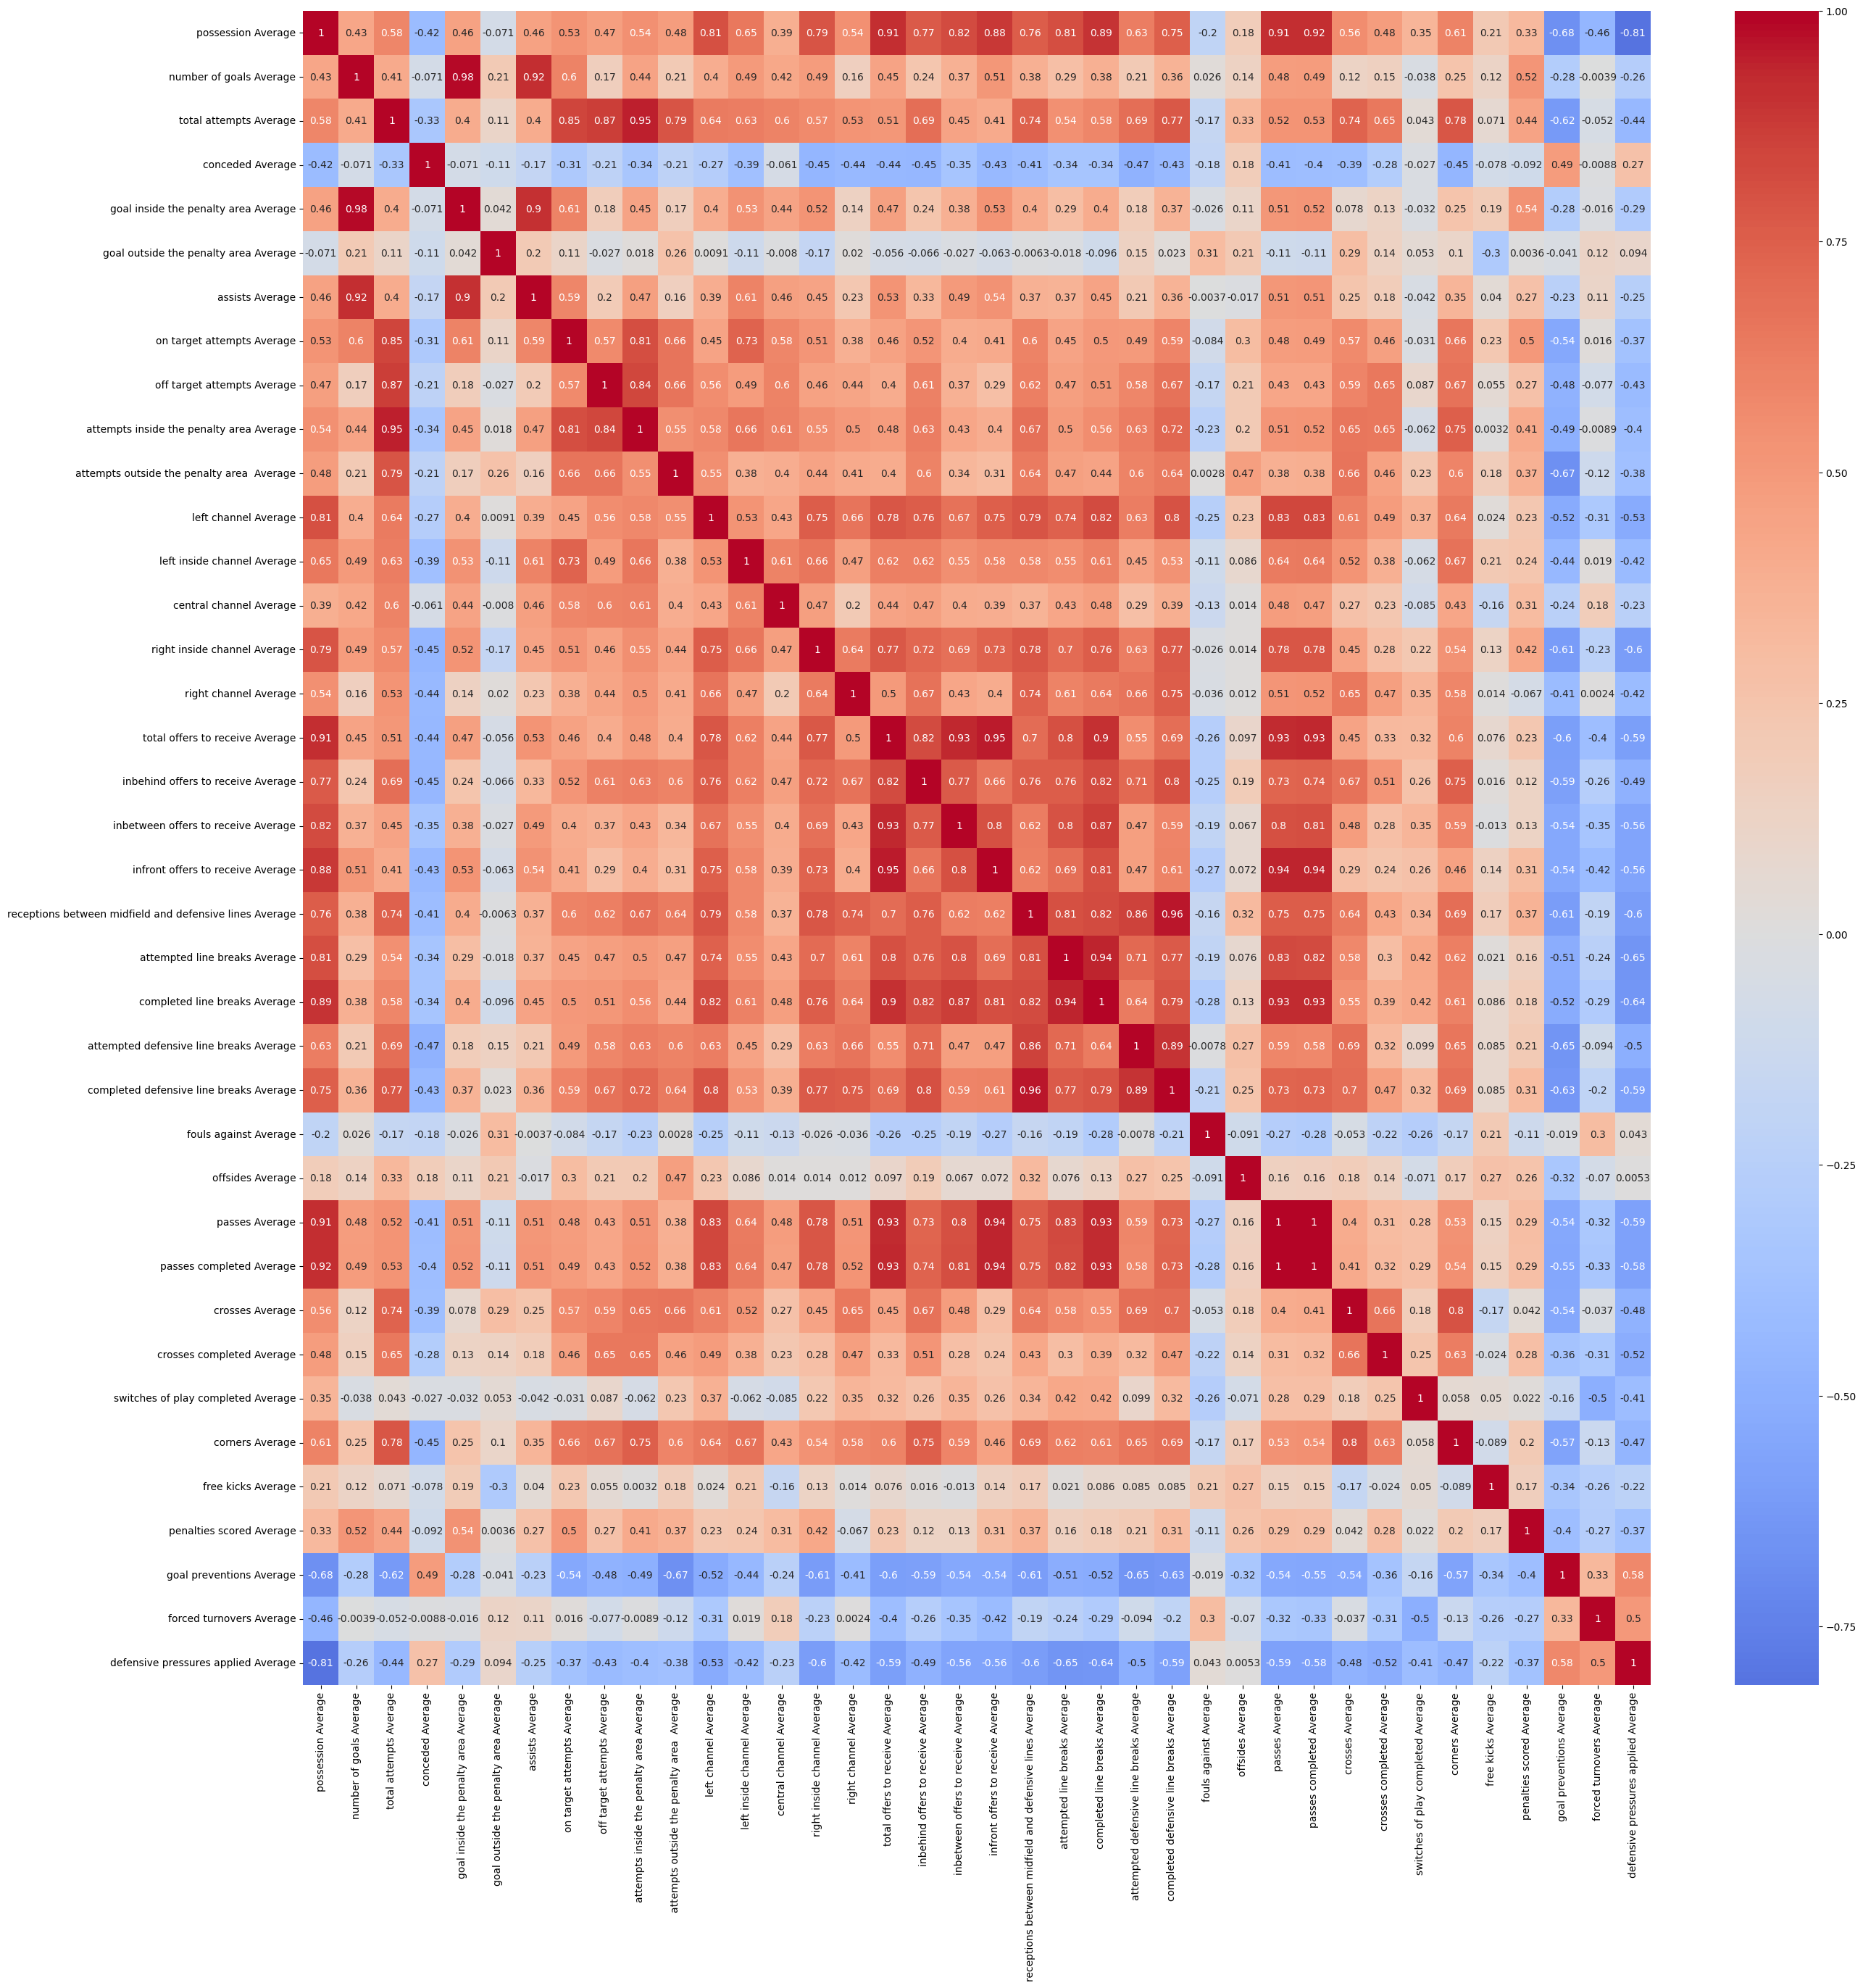

In [42]:
#correlation matrix
correlation_matrix= data_preproccessed.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.show()

# **Data Preprocessing**

In [43]:
data_preproccessed_copy = data_preproccessed.copy()
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_preproccessed_copy),
                                  index = data_preproccessed_copy.index,
                                  columns = data_preproccessed_copy.columns)

# attack_data_scaled = data_scaled[attack]
# defense_data_scaled = data_scaled[defense]

# **Dimension Reducion**

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
<ipython-input-44-142bf9495615>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(data_umap['UMAP1'][i], data_umap['UMAP2'][i], country, fontsize=8)


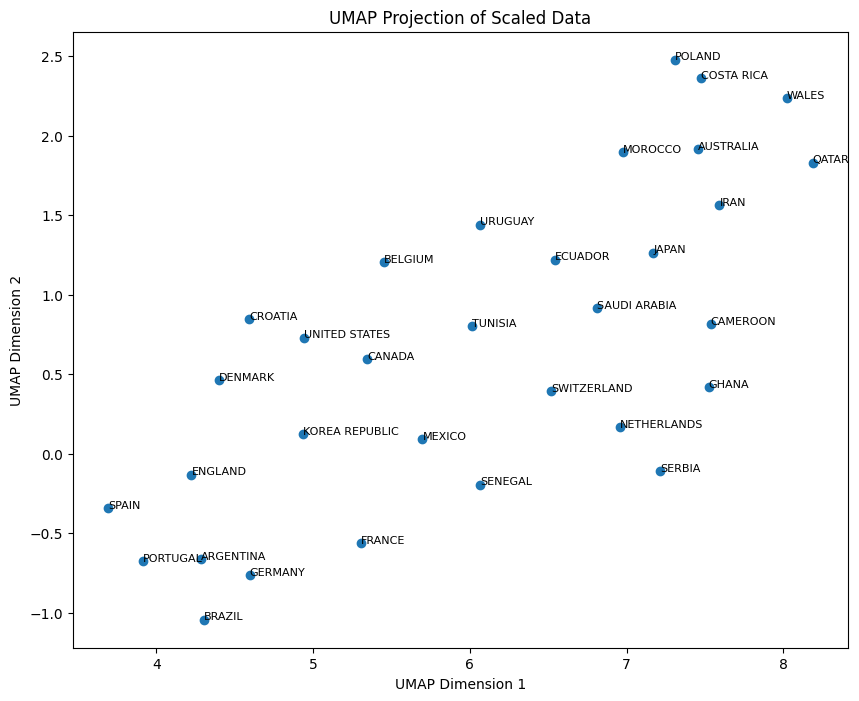

In [44]:
# Create a UMAP model and apply it to the data
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=0)
embedding = reducer.fit_transform(data_scaled)

# Create a DataFrame for the embedding with country names
data_umap = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'], index=data_scaled.index)

# Visualize the UMAP projection
plt.figure(figsize=(10, 8))
plt.scatter(data_umap['UMAP1'], data_umap['UMAP2'])

# Add country labels to the plot
for i, country in enumerate(data_umap.index):
    plt.text(data_umap['UMAP1'][i], data_umap['UMAP2'][i], country, fontsize=8)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Projection of Scaled Data')
plt.show()

# **Clustering**

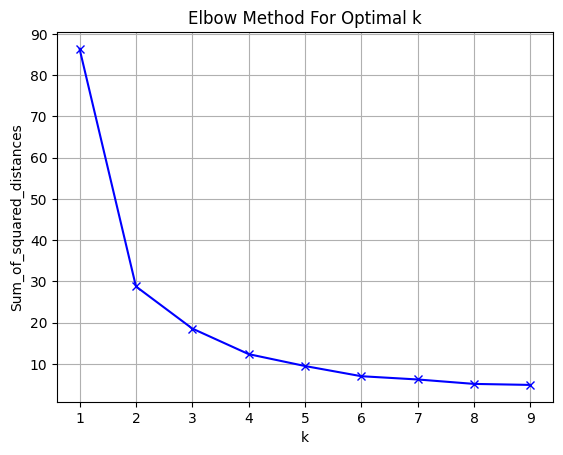

In [45]:
# Calculate sum of squared distances for different k values
sum_of_squared_distances = []

# Range of k values to explore (1 to 0)
k_range = range(1, 10)
for k in k_range:
	# Create a KMeans model with k clusters and fixed random state
    kmeans = KMeans(n_clusters = k, max_iter=1000, random_state=0)
    # Fit the model to the data
    kmeans = kmeans.fit(data_umap)
    # Append the inertia (sum of squared distances) to the list
    sum_of_squared_distances.append(kmeans.inertia_)

# Elbow Method visualization
plt.plot(k_range, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.grid(True)

plt.show()

# **Evaluating model**

In [46]:
k_range = range(2,10) # Range of k values to explore (2 to 13)

# Initialize variables to track best k and score
best_n = -1
best_silhouette_score = -1

for k in k_range:
    # Create a KMeans model with the current k and fixed random state
    kmeans = KMeans(n_clusters = k, max_iter=1000, random_state=0)
    # Fit the model to the embedded data
    kmeans.fit(data_umap)
    # Predict cluster labels for the data
    clusters = kmeans.predict(data_umap)

    # Calculate silhouette score for the current k
    score = silhouette_score(data_umap, clusters)

    # Print results for each k
    print('k :',  k, 'score :', score)

    # Update best k and score if current score is better
    if score > best_silhouette_score:
        best_n = k
        best_silhouette_score = score

# Print results for the best k
print('best n :', best_n, 'best score :', best_silhouette_score )

k : 2 score : 0.5198164
k : 3 score : 0.40123457
k : 4 score : 0.4047293
k : 5 score : 0.39511415
k : 6 score : 0.4342735
k : 7 score : 0.38473302
k : 8 score : 0.35000598
k : 9 score : 0.28183317
best n : 2 best score : 0.5198164


<ipython-input-47-f80ebe600f5b>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(data_umap['UMAP1'][i], data_umap['UMAP2'][i], country, fontsize=8)
<ipython-input-47-f80ebe600f5b>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(data_umap['UMAP1'][i], data_umap['UMAP2'][i], country, fontsize=8)
<ipython-input-47-f80ebe600f5b>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(data_umap['UMAP1'][i], data_umap

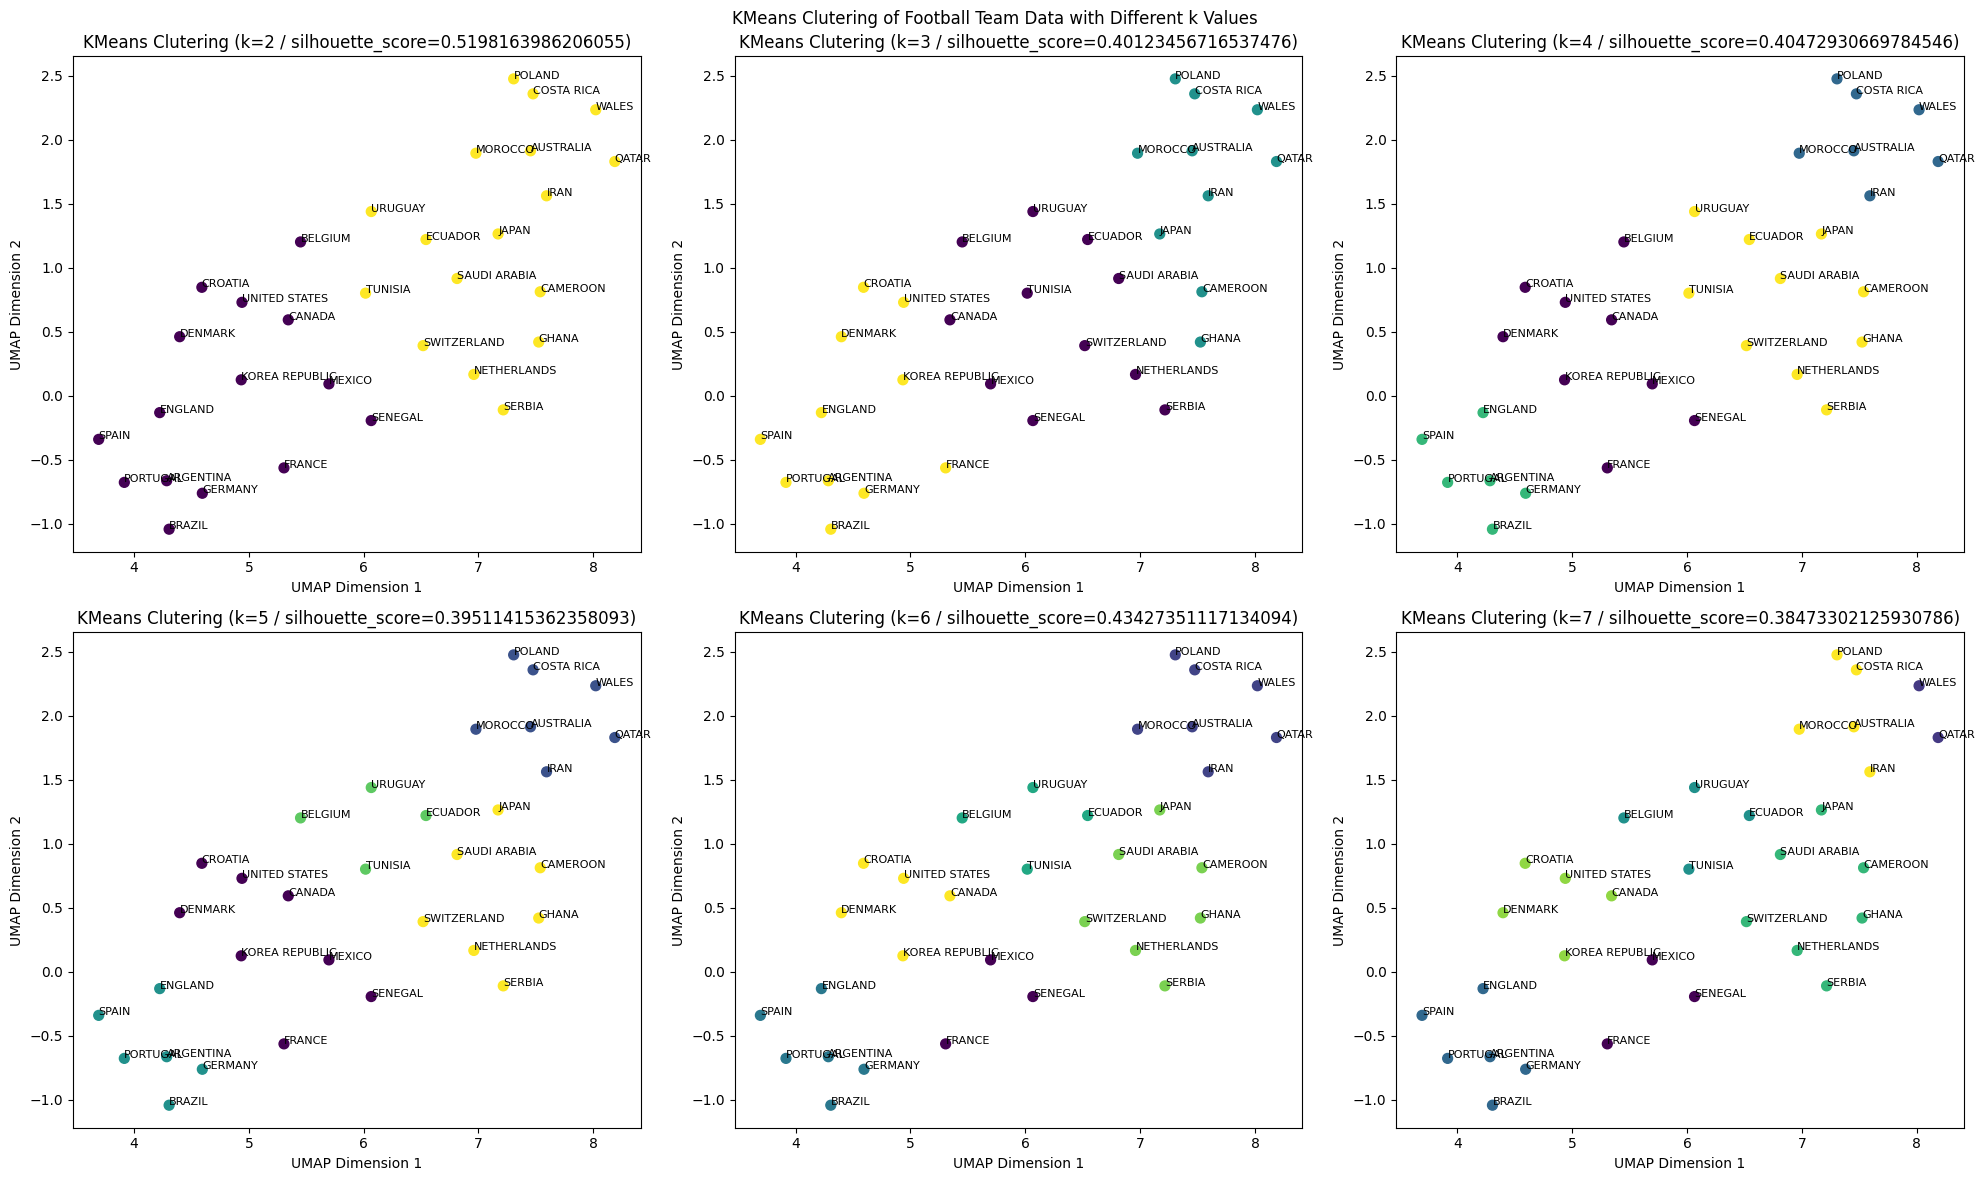

In [47]:
# List of k values to visualize
k_values = [2, 3, 4, 5, 6, 7]

# Create a subplot grid to display multiple plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

for i, k in enumerate(k_values):
    # Create a KMeans model for the current k
    kmeans = KMeans(n_clusters = k, max_iter=1000, random_state=0)
    kmeans.fit(data_umap)
    clusters = kmeans.predict(data_umap)
    score = silhouette_score(data_umap, clusters)

    # Plot for the current k on the corresponding subplot
    ax = axes.flat[i]
    ax.scatter(data_umap['UMAP1'], data_umap['UMAP2'], c=clusters, s=50, cmap='viridis')


    # Add country labels to the plot
    for i, country in enumerate(data_umap.index):
        ax.text(data_umap['UMAP1'][i], data_umap['UMAP2'][i], country, fontsize=8)

    # Set labels and title for each subplot
    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')
    ax.set_title(f'KMeans Clutering (k={k} / silhouette_score={score})')

# Adjust layout and display the plots
fig.suptitle('KMeans Clutering of Football Team Data with Different k Values')
plt.tight_layout()
plt.show()

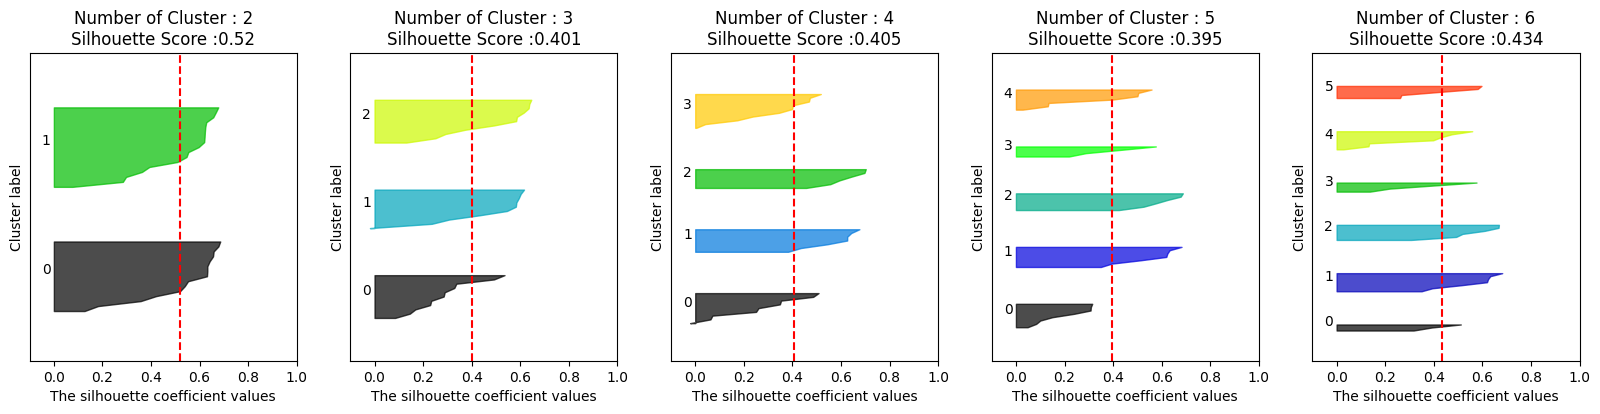

In [48]:
# Visualizes silhouette coefficients for different numbers of clusters.
def visualize_silhouette(cluster_lists, X_features):
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # Get the number of cluster lists
    n_cols = len(cluster_lists)

    # Create subplots based on the number of cluster lists
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

     # Iterate through the cluster lists
    for ind, n_cluster in enumerate(cluster_lists):

        # Perform KMeans clustering and calculate silhouette score and values
        kmeans = KMeans(n_clusters = n_cluster, max_iter=1000, random_state=0)
        cluster_labels = kmeans.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # Plot the silhouette values for each cluster
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

#visualize silhouette scores for 2, 3, 4, and 5 clusters
visualize_silhouette([2, 3, 4, 5, 6], data_umap)

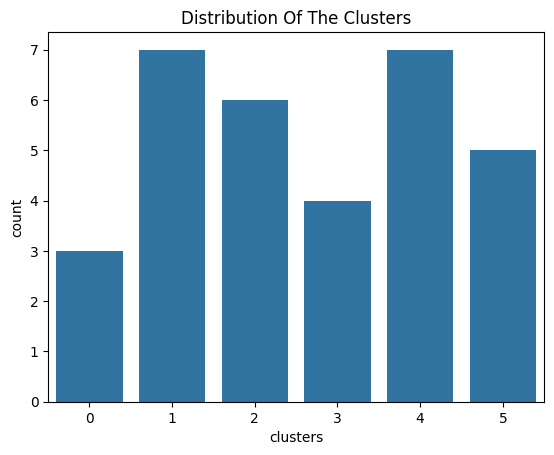

In [49]:
kmeans = KMeans(n_clusters = 6, max_iter=1000, random_state=0)
kmeans.fit(data_umap)
clusters = kmeans.predict(data_umap)
data_umap_copy = data_umap.copy()
data_umap_copy['clusters'] = clusters
pl = sns.countplot(x=data_umap_copy["clusters"])
pl.set_title("Distribution Of The Clusters")
plt.show()

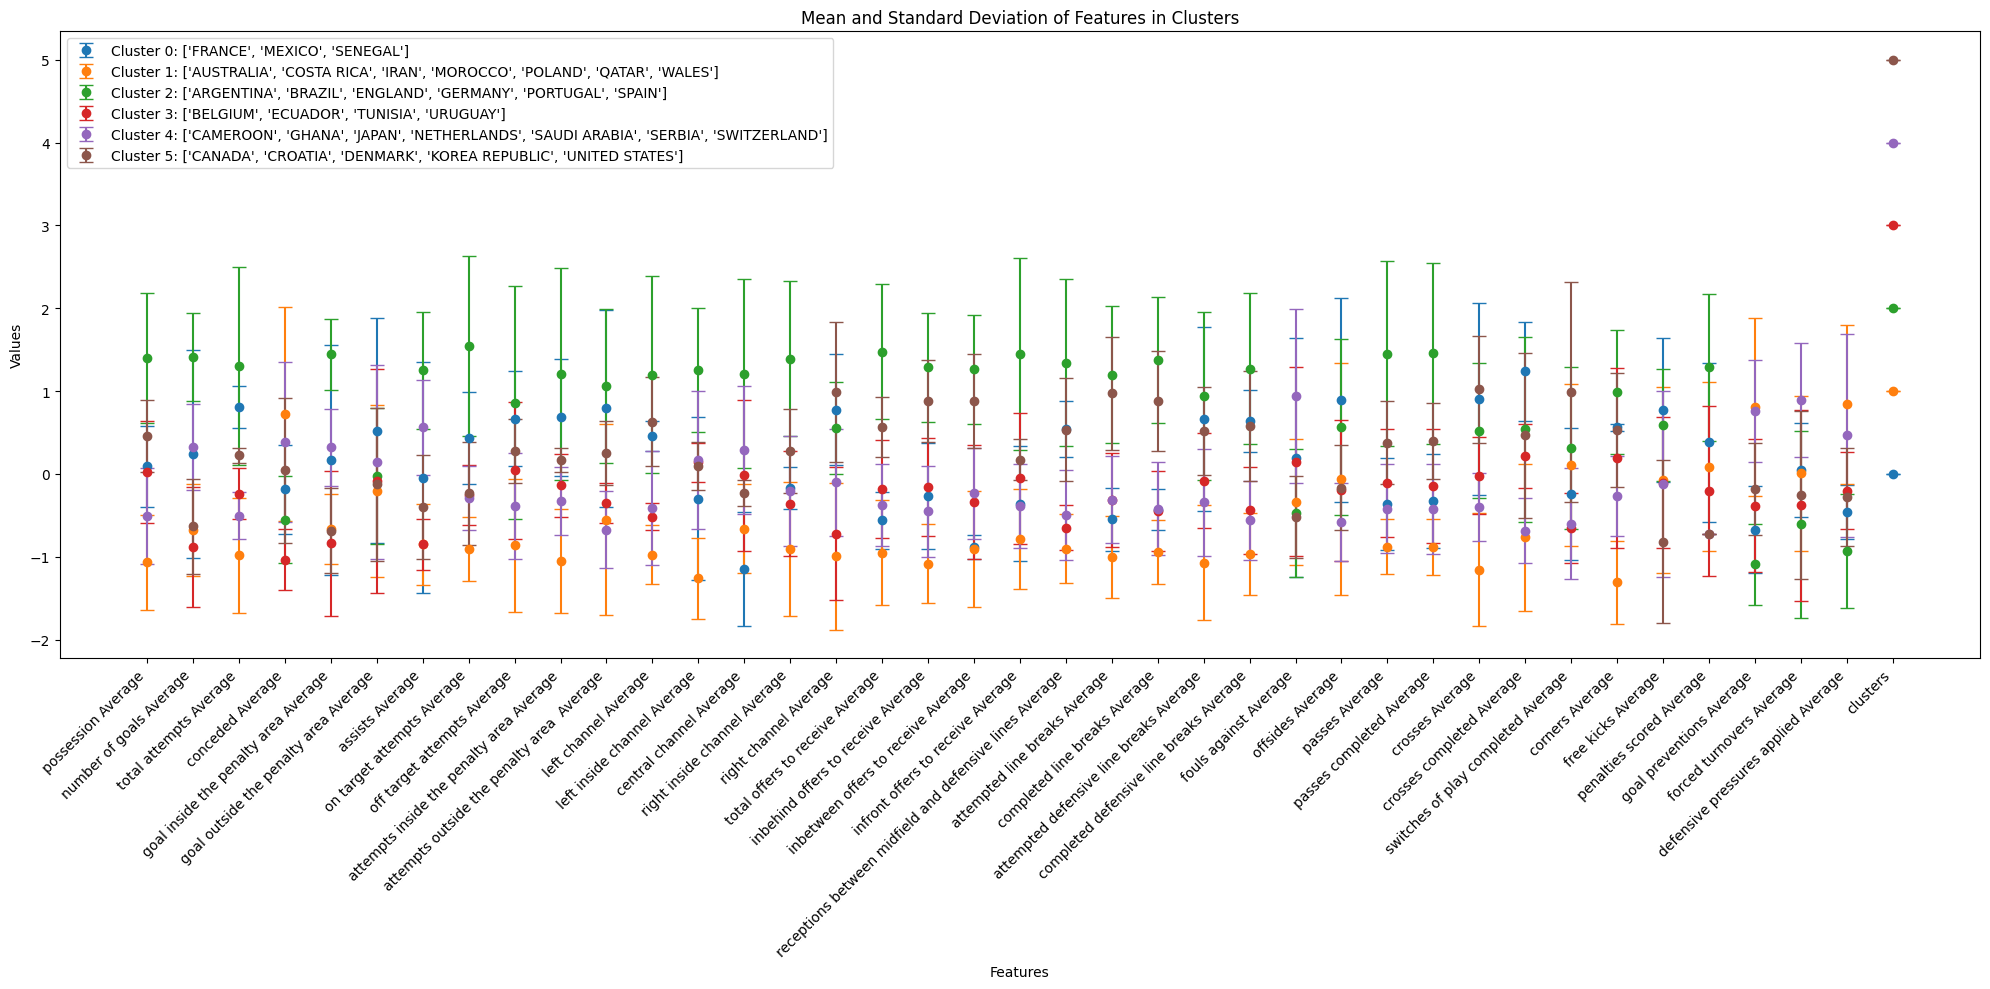

In [50]:
# Plots the mean and standard deviation of features for specified clusters
def plot_cluster_mean_std(data, cluster_column='clusters', clusters_to_plot=None, figsize=(20, 10)):

    if clusters_to_plot is None:
        clusters_to_plot = data[cluster_column].unique()  # Plot all unique clusters

    plt.figure(figsize=figsize)

    for cluster_num in clusters_to_plot:
        cluster_data = data[data[cluster_column] == cluster_num]
        cluster_mean_std = cluster_data.describe().loc[['mean', 'std']]
        country = sorted(data[data['clusters'] == cluster_num].index.tolist())

        plt.errorbar(
            x=cluster_mean_std.columns,
            y=cluster_mean_std.loc['mean'],
            yerr=cluster_mean_std.loc['std'],
            fmt='o',
            capsize=5,
            label=f'Cluster {cluster_num}: {country}'  # Add label for each cluster
        )

    plt.title('Mean and Standard Deviation of Features in Clusters') # More general title
    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.xticks(rotation=45, ha='right')
    plt.legend()  # Show the legend
    plt.tight_layout()
    plt.show()

data_scaled_copy = data_scaled.copy()
data_scaled_copy['clusters'] = clusters
data_scaled_copy = data_scaled_copy.sort_values(by='clusters')

# Plot all clusters
plot_cluster_mean_std(data_scaled_copy)

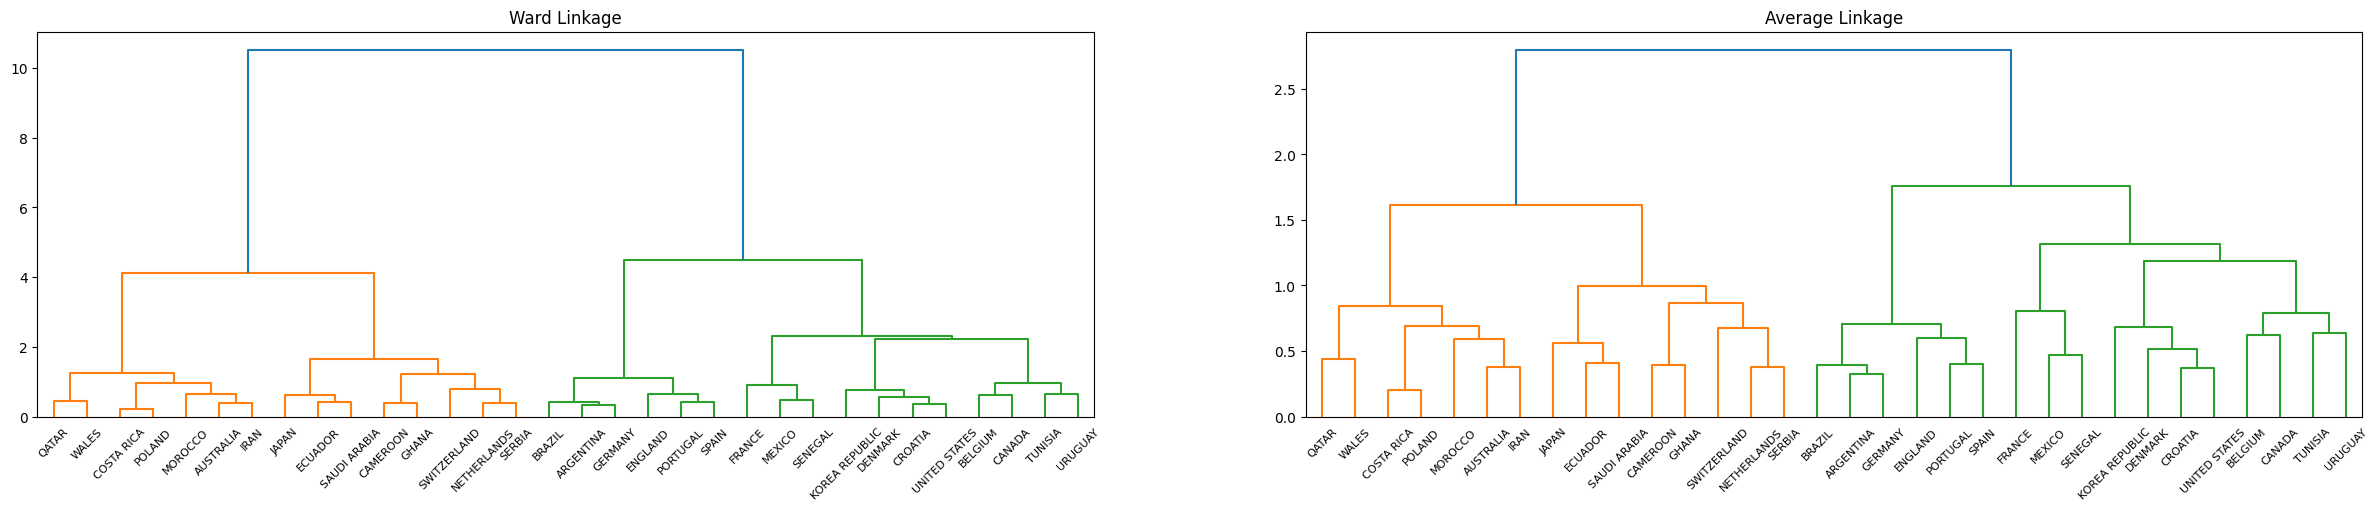

In [53]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering


# Perform hierarchical clustering using Ward's method and average linkage method
linked_ward = linkage(data_umap, 'ward')
linked_average = linkage(data_umap, 'average')


# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 5))

# First dendrogram (Ward's method)
dendrogram(linked_ward, orientation='top', ax=ax1, labels=data_umap.index)
ax1.set_title('Ward Linkage')

# Second dendrogram (Average linkage)
dendrogram(linked_average, orientation='top', ax=ax2, labels=data_umap.index)
ax2.set_title('Average Linkage')

plt.show()

# 공격 지표랑 수비 지표 나눔

In [51]:
# Create a UMAP model and apply it to the data
reducer1 = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
attack_embedding = reducer1.fit_transform(attack_data_scaled)

# Create a DataFrame for the embedding with country names
attack_embedding_df = pd.DataFrame(attack_embedding, columns=['UMAP1', 'UMAP2'], index=attack_data_scaled.index)

# Create a UMAP model and apply it to the data
reducer2 = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
defense_embedding = reducer2.fit_transform(defense_data_scaled)

# Create a DataFrame for the embedding with country names
defense_embedding_df = pd.DataFrame(defense_embedding, columns=['UMAP1', 'UMAP2'], index=defense_data_scaled.index)

NameError: name 'attack_data_scaled' is not defined

In [ ]:
# Dictionary to store the data sets
data_sets = {'Attack Data': attack_embedding_df, 'Defense Data': defense_embedding_df}

# Create a figure and axes for the subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Iterate through the data sets
for i, (data_name, data) in enumerate(data_sets.items()):
    # List to store the sum of squared distances for different k values
    sum_of_squared_distances = []
    # Range of k values to explore (1 to 14)
    K = range(1, 15)
    for k in K:
        # Create a KMeans model with k clusters and a fixed random state for reproducibility
        km = KMeans(n_clusters=k, random_state=42)
        # Fit the model to the data
        km = km.fit(data)
        # Append the inertia (sum of squared distances) to the list
        sum_of_squared_distances.append(km.inertia_)

    # Plot the Elbow Method for the current data set in the corresponding subplot
    axes[i].plot(K, sum_of_squared_distances, 'bx-')
    axes[i].set_xlabel('k')
    axes[i].set_ylabel('Sum_of_squared_distances')
    axes[i].set_title(f'Elbow Method For Optimal k ({data_name})')  # Include data name in the title
    axes[i].grid(True)

# Adjust the spacing between subplots for better readability
plt.tight_layout()
# Display the plot
plt.show()

In [ ]:
# Dictionary to store the data sets
data_sets = {'Attack Data': attack_embedding_df, 'Defense Data': defense_embedding_df}

# Dictionary to store the results: {dataset: {k: score}}
results = {}

# Iterate through the data sets
for data_name, data in data_sets.items():
    # Initialize an inner dictionary for each dataset to store k: score pairs
    results[data_name] = {}

    # Range of k values to explore
    K = range(2, 14)
    # Initialize variables to track the best k and silhouette score
    best_n = -1
    best_silhouette_score = -1

    # Iterate through the range of k values
    for k in K:
        # Create a KMeans model with the current k and a fixed random state for reproducibility
        kmeans = KMeans(n_clusters=k, random_state=42)
        # Fit the model to the data
        kmeans.fit(data)
        # Predict cluster labels for the data
        clusters = kmeans.predict(data)
        # Calculate the silhouette score for the current k
        score = silhouette_score(data, clusters)

        # Store the silhouette score for the current k in the inner dictionary
        results[data_name][k] = score

        # Update the best k and silhouette score if the current score is better
        if score > best_silhouette_score:
            best_n = k
            best_silhouette_score = score

    # Store the best k and silhouette score for the current dataset
    results[data_name]['Best k'] = best_silhouette_score
    results[data_name][best_n] = best_silhouette_score

# Create a Pandas DataFrame from the results dictionary, using dataset names as index
df_results = pd.DataFrame.from_dict(results, orient='index')

# Restructure the DataFrame to have datasets as columns and k values as rows
df_results = df_results.stack().unstack(0)

# Print the resulting DataFrame
print(df_results)